# Manual

In [11]:
# Set hyperparameters
encoding_size = 512
hidden_size = 512
num_layers = 3
dropout = 0 # dropout must be equal 0 if num_layers = 1
teacher_ratio = 0.5

# Set paths

model_path = './models/fixed_cce_3_layers/epoch_25.pt'

val_dataset_path = 'data/GRU_data/val_dataset.parquet'

# Load model

In [12]:
from src.gru.vae_gru import EncoderDecoder
from src.gru.dataset import GRUDataset
from src.utils.vectorizer import SELFIESVectorizer
from src.utils.qed import mean_batch_QED
import selfies as sf
from tqdm import tqdm
import rdkit.Chem as Chem
import torch
import numpy as np
import torch.nn as nn
import pandas as pd
from tqdm import tqdm
import gc

gc.collect()
torch.cuda.empty_cache()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
# Init model
model = EncoderDecoder(
    fp_size=4860,
    encoding_size=encoding_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    dropout=dropout,
    teacher_ratio = teacher_ratio).to(device)

#model.load_state_dict(torch.load('PATH'))
model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))

<All keys matched successfully>

In [14]:
def get_predictions(val_dataset_path, shuffle=False):
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    vectorizer = SELFIESVectorizer(pad_to_len=128)

    val_df = pd.read_parquet(val_dataset_path).reset_index().drop(columns='index')
    val_dataset = GRUDataset(val_df, vectorizer)

    from torch.utils.data import DataLoader
    batch_size = 128
    val_loader = DataLoader(val_dataset, shuffle=shuffle, batch_size=batch_size, drop_last=True)
    
    pred_ms = []
    target_ms = []
    pred_selfies = []
    target_selfies = []
    
    total_QED = 0
    
    X, y = next(iter(val_loader))
    X = X.to(device)
    y = y.to(device)
    preds = model(X, y, teacher_forcing=False)
    preds = preds.detach().cpu().numpy()
    targets = y.detach().cpu().numpy()
    fps = val_df.fps.apply(eval).tolist()
    QED_score = mean_batch_QED(preds, vectorizer)

    for n in range(batch_size):
        selfie_pred = vectorizer.devectorize(preds[n], remove_special=True)
        selfie_target = vectorizer.devectorize(targets[n], remove_special=True)
        pred_selfies.append(selfie_pred)
        target_selfies.append(selfie_target)
        try:
            smiles_pred = sf.decoder(selfie_pred)
        except:
            smiles_pred = 'C'
        smiles_target = sf.decoder(selfie_target)

        pred_ms.append(Chem.MolFromSmiles(smiles_pred))
        target_ms.append(Chem.MolFromSmiles(smiles_target))
    print(f'QED_score: {QED_score}')
    
    return target_ms, pred_ms, target_selfies, pred_selfies, fps

In [15]:
class Highlighter():
    
    def __init__(self, target_ms, pred_ms, fps):
        self.target_ms = target_ms
        self.pred_ms = pred_ms
        self.fps = fps
        self.key = pd.read_csv('data/KlekFP_keys.txt', header=None, names=['smarts']).smarts.values
        
    def __call__(self, k, fp_bit):
        target_mol, pred_mol = self.prepare_molecules(k)
        substruct = self.prepare_substruct(fp_bit)
        target_hits = list(target_mol.GetSubstructMatch(substruct))
        pred_hits = list(pred_mol.GetSubstructMatch(substruct))
        
        custom_legends = [f'target #{k}', 'predicted']
        return(Chem.Draw.MolsToGridImage([target_mol, pred_mol],
                                         molsPerRow=2,
                                         highlightAtomLists = [target_hits, pred_hits],
                                         legends = custom_legends,
                                         subImgSize=(400,400),
                                         returnPNG=False,
                                         useSVG=False))
        
    def prepare_molecules(self, k):
        target_mol = self.target_ms[k]
        pred_mol = self.pred_ms[k]
        return target_mol, pred_mol
    
    def prepare_substruct(self, fp_bit):
        substruct_mol = Chem.MolFromSmarts(self.key[fp_bit])
        return substruct_mol

In [16]:
target_ms, pred_ms, target_selfies, pred_selfies, fps = get_predictions(val_dataset_path)

QED_score: 0.22725467363724486


Target SELFIES:
[O][=C][Branch2][Ring1][#Branch2][N][C][C][C][C][C][=N][C][Branch1][=Branch2][N][C][C][C][C][C][Ring1][=Branch1][=N][C][=C][Ring1][N][Ring1][S][C][C][C][C][C][Ring1][Branch1][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop]

 Predicted SELFIES:
[O][=C][Branch2][Ring1][N][N][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][C][C][C][C][C][C][Ring1][Ring1][C][C][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1]

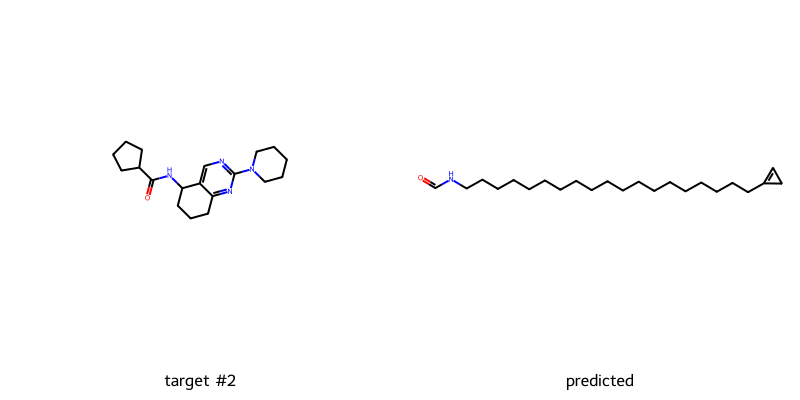

In [20]:
t = 2
highlighter = Highlighter(target_ms, pred_ms, fps)

print('Target SELFIES:')
print(target_selfies[t])
print('\n', 'Predicted SELFIES:')
print(pred_selfies[t])
highlighter(t,2)